# Dependencies

In [ ]:
%matplotlib inline 

import numpy as np
from heapdict import heapdict
from math import floor, sqrt

# for running experiments
import itertools
from multiprocessing import Pool
import pandas as pd
from google.colab import files

# for plotting
from matplotlib import pyplot as plt
from matplotlib import colors
import networkx as nx

# Source Code

In [ ]:
# TYPE_MAPPING is used to colour the tile according to the type
# e.g. all obstacles are in black colour. these tiles will be inaccessible
TYPE_MAPPING = {
    'obstacle' : 'black',
    'source' : 'royalblue',
    'target' : 'green',
    'path' : 'peachpuff',
    'others' : 'white',
    'visited' : 'yellow'
}

# COLOUR_MAPPING is used to assign a value in numpy array so that matplotlib knows which value will be mapped to which colour
# e.g. if coordinate (1,2) has value 0, the tile will be of black colour
COLOUR_MAPPING = {
    'black' : 0,
    'royalblue' : 1,
    'green' : 2,
    'peachpuff'  : 3,
    'white' : 4,
    'yellow' : 5
}

**Graph Implementation**

In [ ]:
class Graph:

    def __init__(self, w, h, seed=0):
        self.COLOUR_MAPPING = COLOUR_MAPPING
        self.TYPE_MAPPING = TYPE_MAPPING

        self.cmap = colors.ListedColormap( list( self.COLOUR_MAPPING.keys() ) )
        self.bounds= list( self.COLOUR_MAPPING.values() ) + [ max(self.COLOUR_MAPPING.values()) +1 ]
        self.norm = colors.BoundaryNorm(self.bounds, self.cmap.N)

        self.w = w
        self.h = h
        self.g = np.full(
            (h, w),
            self.COLOUR_MAPPING[self.TYPE_MAPPING['others']],
            dtype=np.uint8
        )
        self.seed = seed

        self.adjacency_list = {}
        self.source = None
        self.target = None
        self.obstacles = []
    
    def add_obstacle(self, x, y):
        self.g[y,x] = self.COLOUR_MAPPING[ self.TYPE_MAPPING['obstacle'] ]
        self.obstacles += [(x,y)]
    
    def add_source(self, x, y):
        # reset previous source to ensure that there is only one source
        if self.source is not None:
            self.g[self.source[1],self.source[0]] = self.COLOUR_MAPPING[ self.TYPE_MAPPING['others'] ]

        # update new source
        self.g[y,x] = self.COLOUR_MAPPING[ self.TYPE_MAPPING['source'] ]
        self.source = (x,y)
    
    def add_target(self, x, y):
        # reset previous target to ensure that there is only one target
        if self.target is not None:
            self.g[self.target[1],self.target[0]] = self.COLOUR_MAPPING[ self.TYPE_MAPPING['others'] ]
        
        # update new target
        self.g[y,x] = self.COLOUR_MAPPING[ self.TYPE_MAPPING['target'] ]
        self.target = (x,y)

    def generate_random_graph(self, probability_obstacle=0.2):
        np.random.seed(self.seed)

        # generate list of all nodes
        nodes = [ (x,y) for x in range(self.w) for y in range(self.h) ]
        nodes_idx = list( range(self.w * self.h) )
        # print(f"nodes : {nodes}")
        
        # pick one node as the source and remove node from the list
        source_idx = np.random.choice(nodes_idx)
        nodes_idx.remove(source_idx)
        # print(f"source : {source_idx}\n nodes : {nodes_idx}")
        self.add_source(nodes[source_idx][0], nodes[source_idx][1])
        
        # pick one node as the target and remove node from the list
        target_idx = np.random.choice(nodes_idx)
        nodes_idx.remove(target_idx)
        # print(f"target : {target_idx}\n nodes : {nodes_idx}")
        self.add_target(nodes[target_idx][0], nodes[target_idx][1])

        # pick a few nodes as obstacles
        number_obstacles = floor(probability_obstacle * self.w * self.h)
        obstacles_idx = np.random.choice(nodes_idx, size=number_obstacles, replace=False)
        # print(f"obstacles : {obstacles_idx}")
        for obstacles_idx in obstacles_idx:
            self.add_obstacle(nodes[obstacles_idx][0], nodes[obstacles_idx][1])
    
    def add_path(self, x, y):
        # only add path if target or source is not (x,y)
        if (x,y) != self.target and (x,y) != self.source:
            self.g[y,x] = self.COLOUR_MAPPING[ self.TYPE_MAPPING['path'] ]

    def add_paths(self, paths):
        for x,y in paths:
            self.add_path(x,y)

    # Add a single visited node to the list of visited nodes.
    def add_visited_node(self, x, y):
        if (x,y) != self.target and (x,y) != self.source:
            self.g[y,x] = self.COLOUR_MAPPING[ self.TYPE_MAPPING['visited'] ]
    
    # Add a list of visited nodes to the list of visited nodes.
    def add_visited(self, paths):
        for x,y in paths:
            self.add_visited_node(x,y)

    # TODO remove pygame if statements
    def plot(self, plot_type, distance_fn=None):
        if plot_type == 'grid':
            plt.figure( figsize=(self.w, self.h) )

            plt.imshow(
                self.g,
                interpolation = 'none',
                cmap = self.cmap,
                norm = self.norm,
                extent=[0, self.w, self.h, 0] # to ensure that the coordinate plot is adjusted
            )
            plt.ylim((0, self.h))
            plt.xlim((0, self.w))
            plt.xticks(np.arange(0., self.w + 1., 1.))
            plt.yticks(np.arange(0., self.h + 1., 1.))
            plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
            plt.show()

        elif plot_type == 'grid_pygame':
            plt.figure( figsize=(self.w, self.h) )

            plt.imshow(
                self.g,
                interpolation = 'none',
                cmap = self.cmap,
                norm = self.norm
            )
            plt.ylim((0, self.h))
            plt.xlim((0, self.w))
            plt.xticks(np.arange(0., self.w + 1., 1.))
            plt.yticks(np.arange(0., self.h + 1., 1.))
            plt.show()

        elif plot_type == 'graph' and distance_fn is not None:
            # source : https://stackoverflow.com/questions/28372127/add-edge-weights-to-plot-output-in-networkx
            plt.figure( figsize=(self.w, self.h) )
            
            self.g_nx = nx.Graph()
            self.adjacency_list = self.get_adjacency_list(distance_fn)

            nodes = [ (x,y) for x in range(self.w) for y in range(self.h) ]

            for node in nodes:
                self.g_nx.add_node(node, pos=node)

            for node in self.adjacency_list.keys():
                for neighbour, distance in self.adjacency_list[node].items():
                    self.g_nx.add_edge(node, neighbour, weight=distance)

            pos = nx.get_node_attributes(self.g_nx, 'pos')
            nx.draw(self.g_nx, pos)
            labels = nx.get_edge_attributes(self.g_nx, 'weight')
            nx.draw_networkx_edge_labels(self.g_nx, pos, edge_labels=labels)


    def is_valid_coordinate(self, x, y):
        return (x >= 0) and (x < self.w) and (y >= 0) and (y < self.h)

    def add_neighbour(self, current, neighbour, distance_fn):
        x, y = neighbour
        if self.is_valid_coordinate(x, y):
            if self.g[y, x] != self.COLOUR_MAPPING[ self.TYPE_MAPPING['obstacle'] ]:
                self.adjacency_list[current][neighbour] = distance_fn(current, neighbour)
    
    def get_adjacency_list(self, distance_fn):
        '''
        distance_fn needs to be a function that expects 2 inputs and returns float / int
        return adjacency list with the following format
        { (x_source, y_source) :
            { 
                (x_neighbour, y_neighbour) : distance_to_neighbour,
                (x_neighbour, y_neighbour) : distance_to_neighbour
          }
        }
        '''

        self.adjacency_list = {}
        np.random.seed(self.seed)
        for x in range(self.w):
            for y in range(self.h):
                # obstacle node is not added in the adjacency list
                if self.g[y,x] != self.COLOUR_MAPPING[ self.TYPE_MAPPING['obstacle'] ]:
                    self.adjacency_list[ (x,y) ] = {}

                    self.add_neighbour((x,y), (x-1, y-1), distance_fn) # add bottom left
                    self.add_neighbour((x,y), (x, y-1), distance_fn) # add bottom
                    self.add_neighbour((x,y), (x+1, y-1), distance_fn) # add bottom right
                    self.add_neighbour((x,y), (x+1, y), distance_fn) # add right
                    self.add_neighbour((x,y), (x+1, y+1), distance_fn) # add top right
                    self.add_neighbour((x,y), (x, y+1), distance_fn) # add top
                    self.add_neighbour((x,y), (x-1, y+1), distance_fn) # add top left
                    self.add_neighbour((x,y), (x-1, y), distance_fn) # add left
        return self.adjacency_list

**Distance Functions**

In [ ]:
def manhattan_distance(current, target):
    return abs(current[0] - target[0]) + abs(current[1] - target[1])

def diagonal_distance(current, target, lateral_cost=1, diag_cost=sqrt(2)):
    dx = abs(current[0] - target[0])
    dy = abs(current[1] - target[1])
    h = lateral_cost*(dx+dy)  + (diag_cost-2*lateral_cost)*min(dx,dy)
    return h

def euclidian_distance(current, target):
    return sqrt( (current[0]-target[0])**2 + (current[1]-target[1])**2 )

def random_distance(current, target, upper_bound=10):
    return np.random.randint(upper_bound)

def constant_distance(current, target, constant_val=1):
    return 1

**A* Algorithm**

In [ ]:
class Astar:

    def __init__(self, adjacency_list):
        self.adjacency_list = adjacency_list
        self.visited = None
        self.path_len = None

    def initialize_scores(self, init_value=float('inf')):
        scores = {}
        for node in self.adjacency_list.keys():
            scores[node] = init_value
        return scores

    def reconstruct_path_and_cost(self, closed_set, current):
        path = [current]
        cost = 0
        while current in closed_set.keys():
            cost += self.adjacency_list[current][ closed_set[current] ]
            current = closed_set[current]
            path = [current] + path
        self.path_len = len(path)
        return path, cost, len(self.visited)

    def search(self, source, target, heuristic_func):
        self.visited = []
        if source == target:
            return [target], 0

        open_set = heapdict()
        open_set[source] = 0
        closed_set = {}

        gscores = self.initialize_scores()
        gscores[source] = 0
        fscores = self.initialize_scores()
        fscores[source] = heuristic_func(source, target)
        
        while len(open_set) != 0:

            current, f_score = open_set.popitem()
            if current == target:
                return self.reconstruct_path_and_cost(closed_set, current)
            # Add current to visited nodes list.
            if current not in self.visited:
                self.visited.append(current)
            for neighbour, distance in self.adjacency_list[current].items():
                # Add neighbour to visited nodes list
                if neighbour not in self.visited:
                    self.visited.append(neighbour)
                neighbour_gscore = gscores[current] + distance
                # print(f'Neighbour : {neighbour}, gscore : {neighbour_gscore}')
                if neighbour_gscore < gscores[neighbour]:
                    closed_set[neighbour] = current
                    gscores[neighbour] = neighbour_gscore
                    fscores[neighbour] = neighbour_gscore + heuristic_func(neighbour, target)
                    if neighbour not in open_set.keys():
                        open_set[neighbour] = fscores[neighbour]
        return [], float('Inf')

**Variations of A\***

In [ ]:
class Weighted_Astar(Astar):

    def __init__(self, adjacency_list, epsilon=2):
        self.epsilon = epsilon
        super().__init__(adjacency_list)

    def search(self, source, target, heuristic_func):
        self.visited = []
        if source == target:
            return [target], 0

        open_set = heapdict()
        open_set[source] = 0
        closed_set = {}

        gscores = self.initialize_scores()
        gscores[source] = 0
        fscores = self.initialize_scores()
        fscores[source] = heuristic_func(source, target)
        
        while len(open_set) != 0:
            current, f_score = open_set.popitem()
            if current == target:
                return self.reconstruct_path_and_cost(closed_set, current)
            # Add current to visited nodes list.
            if current not in self.visited:
                self.visited.append(current)
            for neighbour, distance in self.adjacency_list[current].items():
                # Add neighbour to visited nodes list
                if neighbour not in self.visited:
                    self.visited.append(neighbour)
                neighbour_gscore = gscores[current] + distance
                if neighbour_gscore < gscores[neighbour]:
                    closed_set[neighbour] = current
                    gscores[neighbour] = neighbour_gscore
                    fscores[neighbour] = neighbour_gscore + (self.epsilon * heuristic_func(neighbour, target))
                    if neighbour not in open_set.keys():
                        open_set[neighbour] = fscores[neighbour]
        return [], float('Inf')


class Beam_Search(Astar):

    def __init__(self, adjacency_list, beam_size=3):
        self.beam_size = beam_size
        super().__init__(adjacency_list)

    def search(self, source, target, heuristic_func):
        self.visited = []
        if source == target:
            return [target], 0

        open_set = heapdict()
        open_set[source] = 0
        closed_set = {}

        gscores = self.initialize_scores()
        gscores[source] = 0
        fscores = self.initialize_scores()
        fscores[source] = heuristic_func(source, target)
        
        while len(open_set) != 0:
            current, f_score = open_set.popitem()
            if current == target:
                return self.reconstruct_path_and_cost(closed_set, current)
            # Add current to visited nodes list.
            if current not in self.visited:
                self.visited.append(current)
            for neighbour, distance in self.adjacency_list[current].items():
                # Add neighbour to visited nodes list
                if neighbour not in self.visited:
                    self.visited.append(neighbour)
                neighbour_gscore = gscores[current] + distance
                if neighbour_gscore < gscores[neighbour]:
                    closed_set[neighbour] = current
                    gscores[neighbour] = neighbour_gscore
                    fscores[neighbour] = neighbour_gscore + heuristic_func(neighbour, target)
                    if neighbour not in open_set.keys():
                        open_set[neighbour] = fscores[neighbour]
            # Enforce beam size.
            if len(open_set) > self.beam_size:
                new_hd = heapdict()
                for i in range(self.beam_size):
                    item, priority = open_set.popitem()
                    new_hd[item] = priority
                open_set = new_hd
        return [], float('Inf')



**Best First Search**

In [ ]:
class BFS:

    def __init__(self, adjacency_list):
        self.adjacency_list = adjacency_list

    def initialize_scores(self, init_value=float('inf')):
        scores = {}
        for node in self.adjacency_list.keys():
            scores[node] = init_value
        return scores

    def reconstruct_path_and_cost(self, closed_set, current):
        path = [current]
        cost = 0
        while current in closed_set.keys():
            cost += self.adjacency_list[current][ closed_set[current] ]
            current = closed_set[current]
            path = [current] + path
        self.path_len = len(path)
        return path, cost, len(self.visited)

    def search(self, source, target, heuristic_func):
        self.visited = []

        if source == target:
            return [target], 0

        open_set = heapdict()
        open_set[source] = 0
        closed_set = {}

        fscores = self.initialize_scores()
        fscores[source] = heuristic_func(source, target)
        
        while len(open_set) != 0:

            current, f_score = open_set.popitem()
            if current == target:
                return self.reconstruct_path_and_cost(closed_set, current)
            if current not in self.visited:
                self.visited.append(current)
            for neighbour, distance in self.adjacency_list[current].items():
                if neighbour not in self.visited:
                    self.visited.append(neighbour)
                neighbour_fscore = fscores[current] 
                if neighbour_fscore < fscores[neighbour]:
                    closed_set[neighbour] = current
                    fscores[neighbour] = neighbour_fscore + heuristic_func(neighbour, target)
                    if neighbour not in open_set.keys():
                        open_set[neighbour] = fscores[neighbour]            
        return [], float('Inf')

# Experiments

4 experiments
*   1 parameter list with BFS
*   1 parameter list with Astar
*   1 parameter list with Dstar
*   RRT will be run offline and source code submitted separately

In [ ]:
size_list = [10, 20, 50]
probability_obstacle_list = [0.1, 0.2, 0.4]
distance_fn_list = [euclidian_distance] # [manhattan_distance, diagonal_distance, euclidian_distance, random_distance, constant_distance]
heuristic_func_list = [euclidian_distance] # [manhattan_distance, diagonal_distance, euclidian_distance, random_distance, constant_distance]
search_algo_list = [Astar, BFS, Weighted_Astar, Beam_Search] # RRT, and other algorithms (James)
n_iter = 3
all_exps = itertools.product(
    size_list,
    probability_obstacle_list,
    distance_fn_list,
    heuristic_func_list,
    search_algo_list
)

def run_exp(parameters):
    size, probability_obstacle, distance_fn, heuristic_func, search_algo = parameters
    g = Graph(w=size, h=size)
    g.generate_random_graph(probability_obstacle=probability_obstacle)
    algo = search_algo( g.get_adjacency_list(distance_fn) )
    search_result = algo.search(g.source, g.target, heuristic_func)
    approx_shortest_distance = heuristic_func(g.source, g.target)
    paths = search_result[0]
    cost = search_result[1]
    visited = search_result[2] if len(search_result) > 2 else None
    return (size, probability_obstacle, distance_fn.__name__, heuristic_func.__name__, search_algo.__name__), approx_shortest_distance, paths, cost, visited

def run_all_exps(all_exps, pool_size):
    with Pool(pool_size) as p:
        return p.map(run_exp, all_exps)

def process_exps_results(results):
    output = []
    for result in results:
        parameters, approx_shortest_distance, paths, cost, visited = result
        size, probability_obstacle, distance_fn, heuristic_func, search_algo = parameters
        output += [{
            'size'                      : size,
            'probability_obstacle'      : probability_obstacle,
            'distance_fn'               : distance_fn,
            'heuristic_fn'              : heuristic_func,
            'search_algo'               : search_algo,
            'approx_shortest_distance'  : approx_shortest_distance,
            'paths_length'              : len(paths),
            'cost'                      : cost,
            'nodes_visited'             : visited     
        }]
        # number of visited nodes
        # approximate shortest distance
    return output

results = run_all_exps(all_exps, 8)
results = process_exps_results(results)
results = pd.DataFrame.from_records(results)
results.to_csv('experiment1_results.csv')
files.download('experiment1_results.csv')
results["env"] = list(zip(
                        results['size'],
                        results['probability_obstacle'],
                        results['distance_fn'],
                        results['heuristic_fn'],
                        results['approx_shortest_distance'] ))
results.pivot(index=['env', 'search_algo'],
              columns=[],
              values=['paths_length', 'cost', 'nodes_visited'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

paths_length  \
env                                                search_algo                    
(10, 0.1, euclidian_distance, euclidian_distanc... Astar                    5.0   
                                                   BFS                      5.0   
                                                   Weighted_Astar           5.0   
                                                   Beam_Search              5.0   
(10, 0.2, euclidian_distance, euclidian_distanc... Astar                    5.0   
                                                   BFS                      5.0   
                                                   Weighted_Astar           5.0   
                                                   Beam_Search              5.0   
(10, 0.4, euclidian_distance, euclidian_distanc... Astar                    5.0   
                                                   BFS                      5.0   
                                                   Weighted_Astar           5.0   
                                                   Beam_Search              5.0   
(20, 0.1, euclidian_distance, euclidian_distanc... Astar                    7.0   
                                                   BFS                      7.0   
                                                   Weighted_Astar           7.0   
                                                   Beam_Search              7.0   
(20, 0.2, euclidian_distance, euclidian_distanc... Astar                    7.0   
                                                   BFS                      7.0   
                                                   Weighted_Astar           7.0   
                                                   Beam_Search              7.0   
(20, 0.4, euclidian_distance, euclidian_distanc... Astar                    7.0   
                                                   BFS                      7.0   
                                                   Weighted_Astar           7.0   
                                                   Beam_Search              7.0   
(50, 0.1, euclidian_distance, euclidian_distanc... Astar                   33.0   
                                                   BFS                     33.0   
                                                   Weighted_Astar          33.0   
                                                   Beam_Search             33.0   
(50, 0.2, euclidian_distance, euclidian_distanc... Astar                   33.0   
                                                   BFS                     33.0   
                                                   Weighted_Astar          33.0   
                                                   Beam_Search             33.0   
(50, 0.4, euclidian_distance, euclidian_distanc... Astar                   33.0   
                                                   BFS                     33.0   
                                                   Weighted_Astar          35.0   
                                                   Beam_Search             38.0   

                                                                        cost  \
env                                                search_algo                 
(10, 0.1, euclidian_distance, euclidian_distanc... Astar            4.000000   
                                                   BFS              4.000000   
                                                   Weighted_Astar   4.000000   
                                                   Beam_Search      4.000000   
(10, 0.2, euclidian_distance, euclidian_distanc... Astar            4.000000   
                                                   BFS              4.000000   
                                                   Weighted_Astar   4.000000   
                                                   Beam_Search      4.000000   
(10, 0.4, euclidian_distance, euclidian_distanc... Astar            4.828427   
                                

In [ ]:
size_list = [10, 20, 50]
probability_obstacle_list = [0.1, 0.2, 0.4]
all_params = itertools.product(
    size_list,
    probability_obstacle_list
)
all_graphs = []
for param in all_params:
    size, probability_obstacle = param
    g = Graph(size, size)
    g.generate_random_graph(probability_obstacle=probability_obstacle)
    all_graphs += [{
        'size' : size,
        'source' : g.source,
        'target' : g.target,
        'obstacles' : g.obstacles
    }]
print(all_graphs)

[{'size': 10, 'source': (4, 4), 'target': (4, 8), 'obstacles': [(2, 6), (8, 8), (0, 2), (5, 7), (7, 7), (9, 5), (1, 6), (7, 5), (5, 6), (9, 7)]}, {'size': 10, 'source': (4, 4), 'target': (4, 8), 'obstacles': [(2, 6), (8, 8), (0, 2), (5, 7), (7, 7), (9, 5), (1, 6), (7, 5), (5, 6), (9, 7), (5, 5), (9, 4), (8, 0), (1, 3), (0, 7), (3, 0), (2, 2), (2, 4), (3, 3), (0, 8)]}, {'size': 10, 'source': (4, 4), 'target': (4, 8), 'obstacles': [(2, 6), (8, 8), (0, 2), (5, 7), (7, 7), (9, 5), (1, 6), (7, 5), (5, 6), (9, 7), (5, 5), (9, 4), (8, 0), (1, 3), (0, 7), (3, 0), (2, 2), (2, 4), (3, 3), (0, 8), (4, 3), (6, 4), (0, 3), (7, 3), (4, 6), (5, 0), (0, 6), (4, 5), (8, 4), (7, 8), (6, 2), (8, 2), (9, 2), (7, 0), (5, 3), (2, 7), (1, 8), (5, 8), (6, 5), (7, 6)]}, {'size': 20, 'source': (8, 12), 'target': (2, 7), 'obstacles': [(6, 13), (15, 11), (17, 3), (9, 18), (12, 8), (3, 1), (7, 16), (13, 3), (7, 2), (10, 16), (1, 17), (6, 15), (5, 14), (17, 10), (0, 12), (3, 0), (14, 15), (7, 1), (10, 8), (10, 1), 

In [ ]:
# Experiment 2

size_list = [75, 100, 125]
probability_obstacle_list = [0.05]
distance_fn_list = [euclidian_distance] # [manhattan_distance, diagonal_distance, euclidian_distance, random_distance, constant_distance]
heuristic_func_list = [euclidian_distance] # [manhattan_distance, diagonal_distance, euclidian_distance, random_distance, constant_distance]
search_algo_list = [Astar, BFS, Weighted_Astar, Beam_Search] # RRT, and other algorithms (James)
n_iter = 3
all_exps = itertools.product(
    size_list,
    probability_obstacle_list,
    distance_fn_list,
    heuristic_func_list,
    search_algo_list
)

def run_exp(parameters):
    size, probability_obstacle, distance_fn, heuristic_func, search_algo = parameters
    g = Graph(w=size, h=size)
    g.generate_random_graph(probability_obstacle=probability_obstacle)
    algo = search_algo( g.get_adjacency_list(distance_fn) )
    search_result = algo.search(g.source, g.target, heuristic_func)
    approx_shortest_distance = heuristic_func(g.source, g.target)
    paths = search_result[0]
    cost = search_result[1]
    visited = search_result[2] if len(search_result) > 2 else None
    return (size, probability_obstacle, distance_fn.__name__, heuristic_func.__name__, search_algo.__name__), approx_shortest_distance, paths, cost, visited

def run_all_exps(all_exps, pool_size):
    with Pool(pool_size) as p:
        return p.map(run_exp, all_exps)

def process_exps_results(results):
    output = []
    for result in results:
        parameters, approx_shortest_distance, paths, cost, visited = result
        size, probability_obstacle, distance_fn, heuristic_func, search_algo = parameters
        output += [{
            'size'                      : size,
            'probability_obstacle'      : probability_obstacle,
            'distance_fn'               : distance_fn,
            'heuristic_fn'              : heuristic_func,
            'search_algo'               : search_algo,
            'approx_shortest_distance'  : approx_shortest_distance,
            'paths_length'              : len(paths),
            'cost'                      : cost,
            'nodes_visited'             : visited     
        }]
        # number of visited nodes
        # approximate shortest distance
    return output

results = run_all_exps(all_exps, 8)
results = process_exps_results(results)
results = pd.DataFrame.from_records(results)
results.to_csv('experiment2_results.csv')
files.download('experiment2_results.csv')
results["env"] = list(zip(
                        results['size'],
                        results['probability_obstacle'],
                        results['distance_fn'],
                        results['heuristic_fn'],
                        results['approx_shortest_distance'] ))
results.pivot(index=['env', 'search_algo'],
              columns=[],
              values=['paths_length', 'cost', 'nodes_visited'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

paths_length  \
env                                                search_algo                    
(75, 0.05, euclidian_distance, euclidian_distan... Astar                   26.0   
                                                   BFS                     26.0   
                                                   Weighted_Astar          26.0   
                                                   Beam_Search             26.0   
(100, 0.05, euclidian_distance, euclidian_dista... Astar                   72.0   
                                                   BFS                     76.0   
                                                   Weighted_Astar          72.0   
                                                   Beam_Search             72.0   
(125, 0.05, euclidian_distance, euclidian_dista... Astar                   66.0   
                                                   BFS                     66.0   
                                                   Weighted_Astar          66.0   
                                                   Beam_Search             66.0   

                                                                        cost  \
env                                                search_algo                 
(75, 0.05, euclidian_distance, euclidian_distan... Astar           25.828427   
                                                   BFS             31.627417   
                                                   Weighted_Astar  25.828427   
                                                   Beam_Search     25.828427   
(100, 0.05, euclidian_distance, euclidian_dista... Astar           76.798990   
                                                   BFS             95.710678   
                                                   Weighted_Astar  76.798990   
                                                   Beam_Search     76.798990   
(125, 0.05, euclidian_distance, euclidian_dista... Astar           88.610173   
                                                   BFS             89.438600   
                                                   Weighted_Astar  88.610173   
                                                   Beam_Search     88.610173   

                                                                   nodes_visited  
env                                                search_algo                    
(75, 0.05, euclidian_distance, euclidian_distan... Astar                   135.0  
                                                   BFS                     680.0  
                                                   Weighted_Astar           82.0  
                                                   Beam_Search              95.0  
(100, 0.05, euclidian_distance, euclidian_dista... Astar                  1108.0  
                                                   BFS                    5363.0  
                                                   Weighted_Astar          231.0  
                                                   Beam_Search             336.0  
(125, 0.05, euclidian_distance, euclidian_dista... Astar                   785.0  
                                                   BFS                    3897.0  
                                                   Weighted_Astar          298.0  
                                                   Beam_Search             333.0

In [ ]:
size_list = [75, 100, 125]
probability_obstacle_list = [0.05]
all_params = itertools.product(
    size_list,
    probability_obstacle_list
)
all_graphs = []
for param in all_params:
    size, probability_obstacle = param
    g = Graph(size, size)
    g.generate_random_graph(probability_obstacle=probability_obstacle)
    all_graphs += [{
        'size' : size,
        'source' : g.source,
        'target' : g.target,
        'obstacles' : g.obstacles
    }]
print(all_graphs)

[{'size': 75, 'source': (36, 32), 'target': (34, 57), 'obstacles': [(46, 45), (38, 1), (71, 28), (18, 40), (37, 22), (67, 73), (9, 56), (34, 3), (19, 36), (10, 44), (50, 10), (5, 68), (18, 64), (4, 11), (8, 29), (50, 72), (6, 69), (2, 52), (51, 26), (65, 64), (61, 49), (68, 12), (23, 27), (8, 8), (37, 65), (69, 14), (40, 21), (7, 10), (48, 17), (61, 54), (74, 4), (52, 11), (58, 49), (4, 2), (74, 39), (42, 48), (67, 31), (39, 32), (50, 22), (30, 16), (53, 34), (61, 62), (12, 10), (35, 40), (15, 20), (44, 53), (1, 59), (40, 50), (68, 16), (42, 65), (70, 65), (37, 24), (42, 10), (1, 69), (7, 23), (59, 60), (60, 14), (47, 56), (70, 5), (27, 42), (72, 62), (53, 53), (24, 28), (35, 27), (69, 49), (31, 39), (74, 18), (5, 13), (48, 41), (48, 11), (0, 15), (7, 5), (45, 66), (45, 55), (32, 1), (2, 67), (0, 39), (12, 18), (7, 14), (51, 64), (71, 4), (73, 6), (2, 64), (1, 67), (72, 31), (47, 19), (46, 9), (40, 52), (30, 5), (31, 34), (72, 15), (24, 65), (0, 29), (39, 56), (70, 72), (5, 6), (33, 9)

# Quickstart

**Manual Graph Creation**

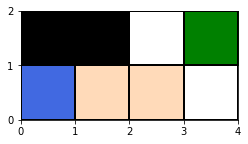

In [ ]:
# initialize grid with width=4 and height=2
# note that x can range from 0 (inclusive) to 3 (inclusive)
# note that y can range from 0 (inclusive) to 1 (inclusive)
g = Graph(4,2)

# add obstacle at coordinate x=1, y=1
g.add_obstacle(1,1)

# add obstacle at coordinate x=0, y=1
g.add_obstacle(0,1)

# add source at coordinate x=0, y=0
g.add_source(0,0)

# add target at coordinate x=3, y=1
g.add_target(3,1)

# one of the shortest path
g.add_path(1,0)
g.add_path(2,0)

# source : blue, obstacle : black, path : cream, target : green
g.plot('grid')

{(0, 0): {(1, 0): 1},
 (1, 0): {(0, 0): 1, (2, 0): 1, (2, 1): 2},
 (2, 0): {(1, 0): 1, (2, 1): 1, (3, 0): 1, (3, 1): 2},
 (2, 1): {(1, 0): 2, (2, 0): 1, (3, 0): 2, (3, 1): 1},
 (3, 0): {(2, 0): 1, (2, 1): 2, (3, 1): 1},
 (3, 1): {(2, 0): 2, (2, 1): 1, (3, 0): 1}}


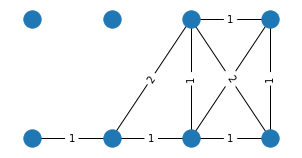

In [ ]:
from pprint import pprint
# generate adjacency list of the graph
# note that obstacles coordinates are excluded (0,1) and (1,1)
'''
input :
distance_fn needs to be a function that expects 2 inputs and returns float / int
        for constant distance : lambda current, neighbour : 3
        for linear distance : lambda current, neighbour : abs(current[0] - neighbour[0]) + abs(current[1] - neighbour[1])
        for random distance : lambda current, neighbour : np.random.randint(10)

output format
{ (x_source, y_source) : [ 
    (distance_to_neighbour, (x_neighbour, y_neighbour)),
    (distance_to_neighbour, (x_neighbour, y_neighbour))
] }
'''

distance_fn = lambda current, neighbour : abs(current[0] - neighbour[0]) + abs(current[1] - neighbour[1])

pprint( g.get_adjacency_list(distance_fn = distance_fn) )

# to visualize adjacency list as a graph
g.plot(
    plot_type   = 'graph',
    distance_fn = distance_fn
)

# Qucickstart Example: Weighted A*

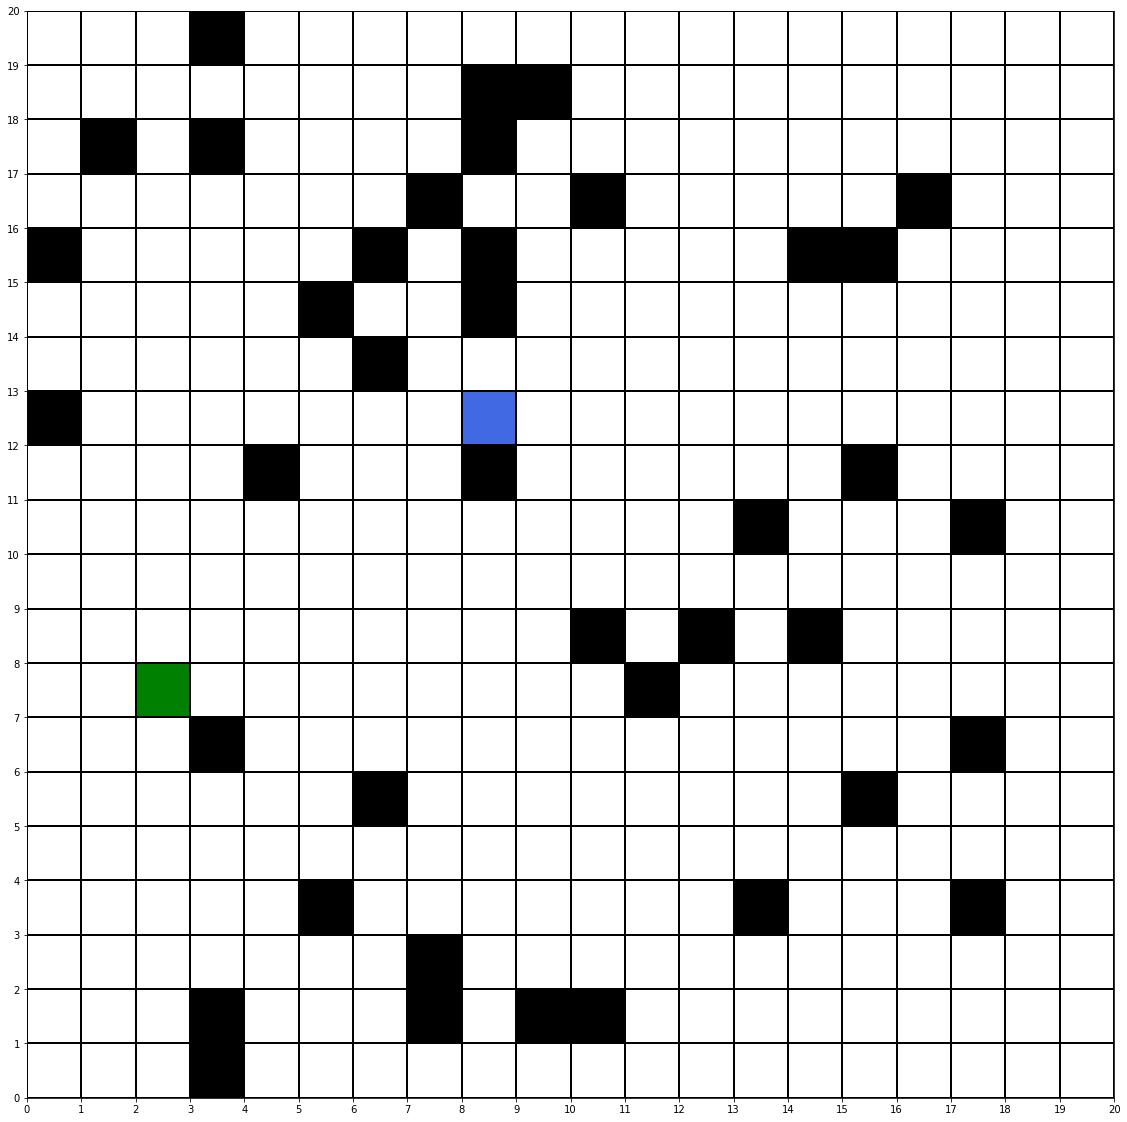

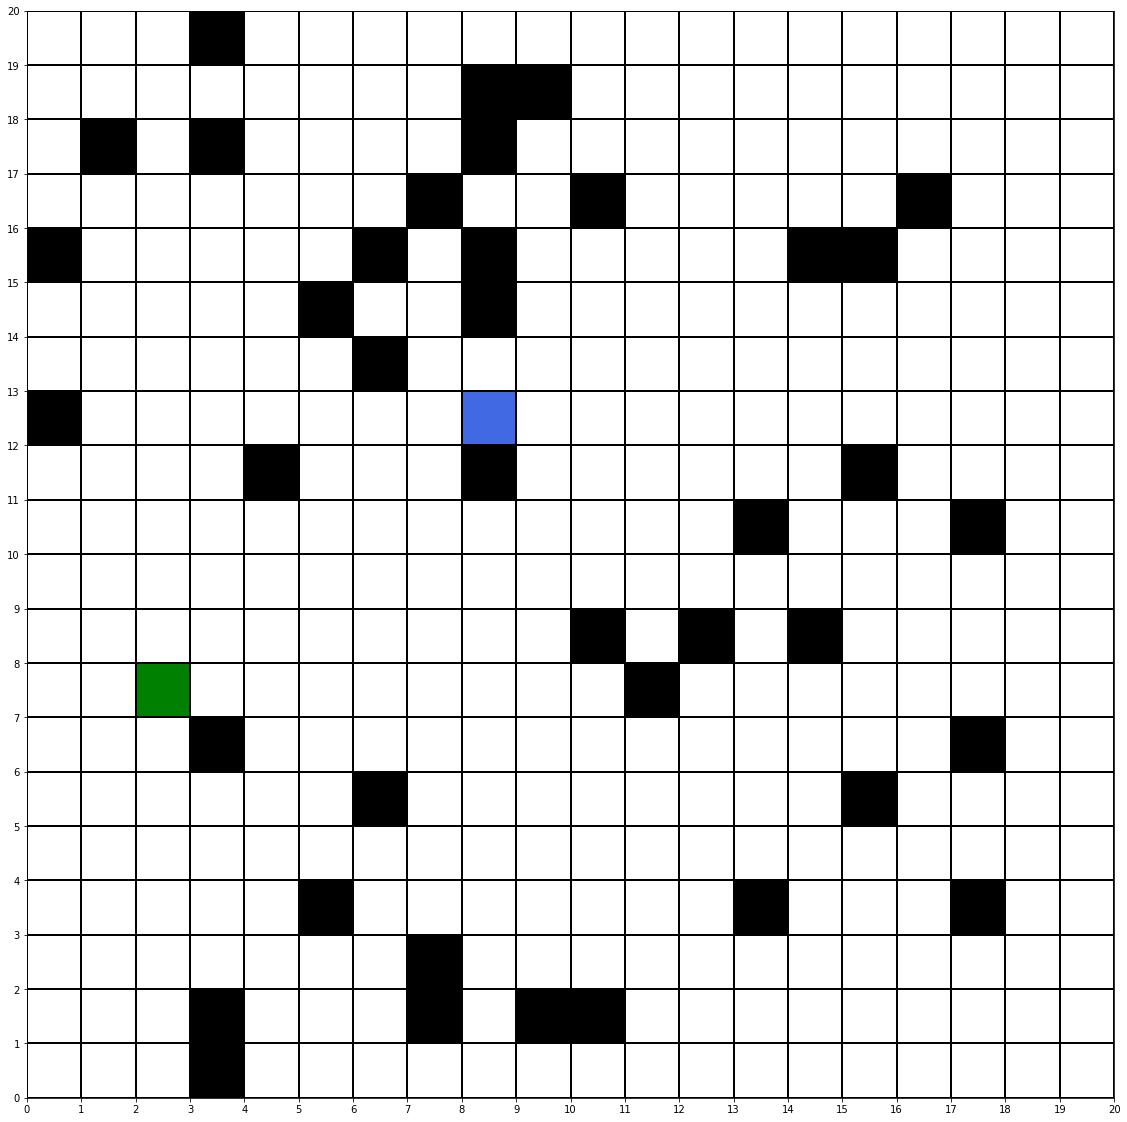

In [ ]:
##############################
#  WEIGHTED A* epsilon=2   #
##############################

# Performance Note:
#
# For the above search space, increasing the epsilon from 1 to 2 delivers
# a 79% decrease in nodes visited for only a 5% increase in path length.

zxi = Graph(20,20)
# generate graph with probability of obstacle = 0.3
zxi.generate_random_graph(0.1)

# distance_fn = lambda current, neighbour : abs(current[0] - neighbour[0]) + abs(current[1] - neighbour[1])
# a = Weighted_Astar(zxi.get_adjacency_list(distance_fn), epsilon=2)

# paths, cost, visited = a.search(zxi.source, zxi.target, diagonal_distance)
# zxi.add_visited(a.visited)
# zxi.add_paths(paths)
# # source : blue, obstacle : black, path : cream, target : green
# # visualize sample problem
# print("Visited: ", len(a.visited))
# print("Path length: ", a.path_len)
# print("Cost :", cost)
zxi.plot('grid')

Visited:  530
Path length:  39
Cost : 49


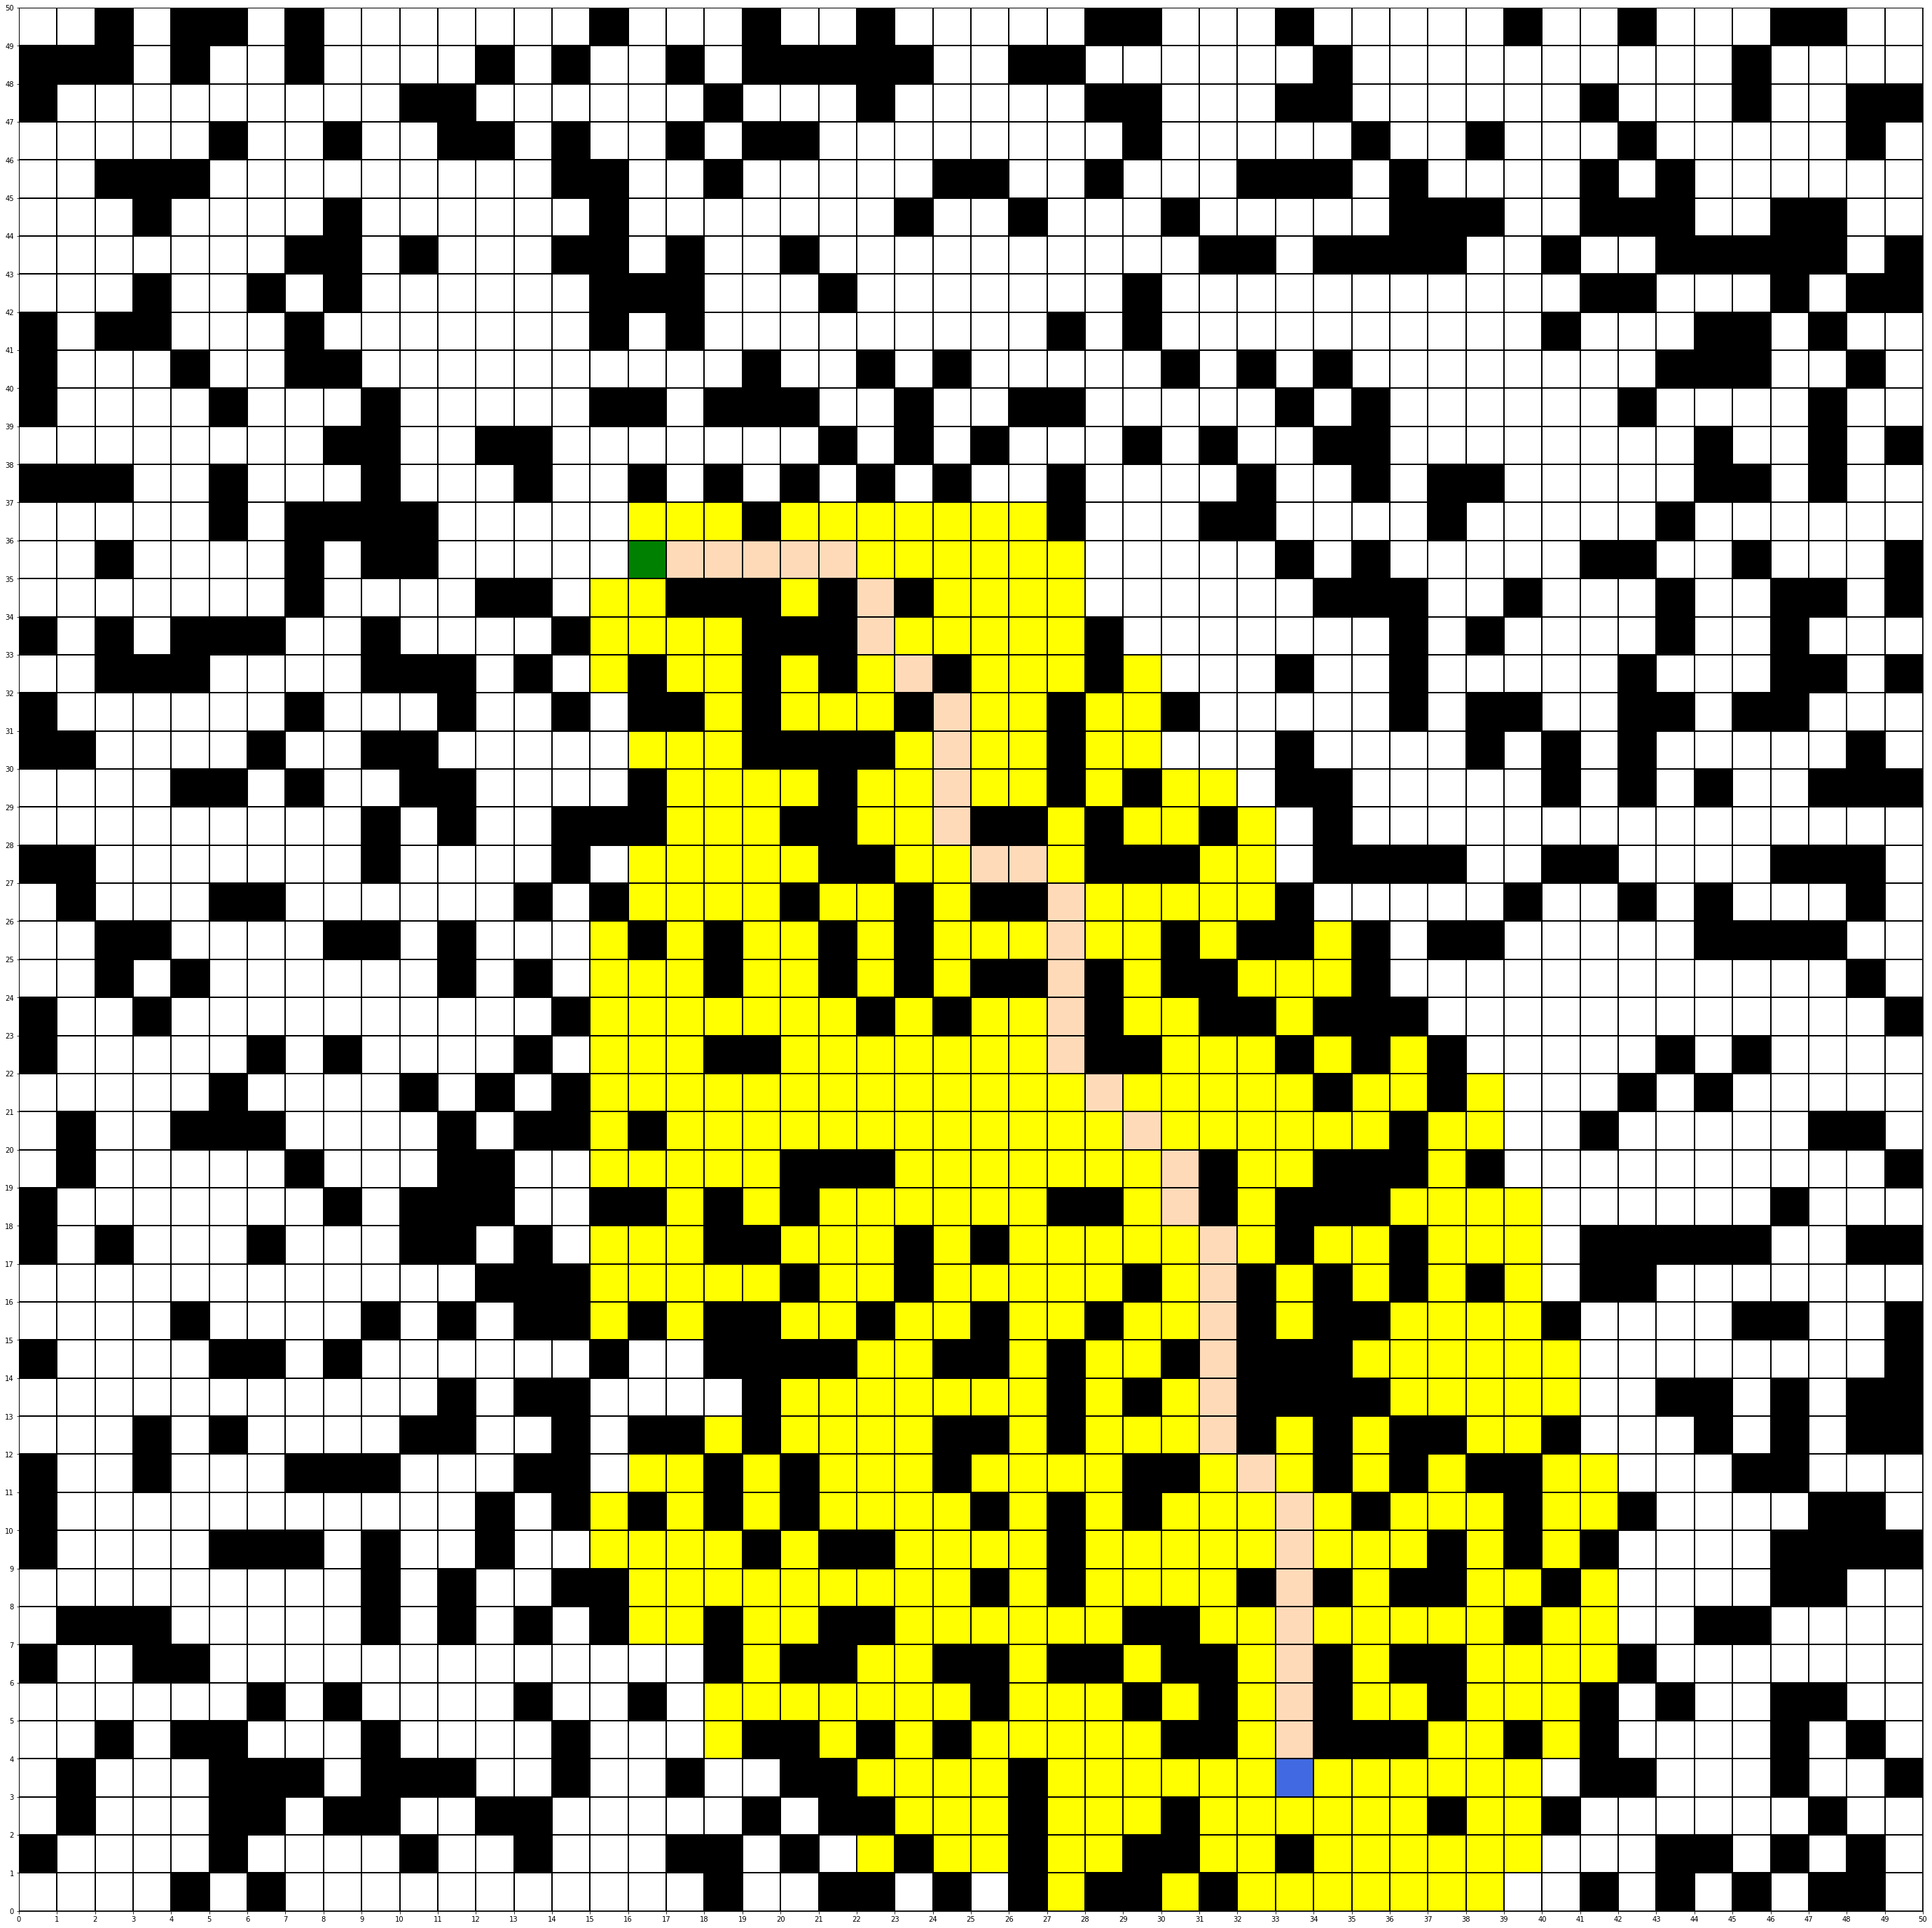

In [ ]:
##############################
#  A*  #
##############################

zxi = Graph(50,50)
# generate graph with probability of obstacle = 0.3
zxi.generate_random_graph(0.3)

distance_fn = lambda current, neighbour : abs(current[0] - neighbour[0]) + abs(current[1] - neighbour[1])
a = Astar(zxi.get_adjacency_list(distance_fn))

paths, cost, visited = a.search(zxi.source, zxi.target, diagonal_distance)
zxi.add_visited(a.visited)
zxi.add_paths(paths)
# source : blue, obstacle : black, path : cream, target : green
# visualize sample problem
print("Visited: ", len(a.visited))
print("Path length: ", a.path_len)
print("Cost :", cost)
zxi.plot('grid')